In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance/insurance.csv


<a id="1"></a> <br>
# 1. Import Necessary Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<a id="1"></a> <br>
# 2. Import Dataset

In [3]:
data = pd.read_csv('/kaggle/input/insurance/insurance.csv')

<a id="1"></a> <br>
# 3. Exploratory Data Analysis

In [4]:
data.sample(10)

,age,sex,bmi,children,smoker,region,charges
271,50,male,34.200,2,yes,southwest,42856.83800
325,40,male,34.105,1,no,northeast,6600.20595
1214,27,female,31.255,1,no,northwest,3956.07145
853,53,female,23.750,2,no,northeast,11729.67950
1335,18,female,36.850,0,no,southeast,1629.83350
929,41,male,34.210,1,no,southeast,6289.75490
1321,62,male,26.695,0,yes,northeast,28101.33305
343,63,male,36.765,0,no,northeast,13981.85035
1209,59,male,37.100,1,no,southwest,12347.17200
168,19,female,31.825,1,no,northwest,2719.27975


In [5]:
# checking missing values:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

There is no missing value in dataset.

In [6]:
# checking nunique and type per columns:
df_nunique = pd.DataFrame([[col , data[col].nunique(),data[col].dtypes] for col in data.columns],columns=['col','nunique','type'])
df_nunique

,col,nunique,type
0,age,47,int64
1,sex,2,object
2,bmi,548,float64
3,children,6,int64
4,smoker,2,object
5,region,4,object
6,charges,1337,float64


<AxesSubplot:xlabel='sex', ylabel='count'>

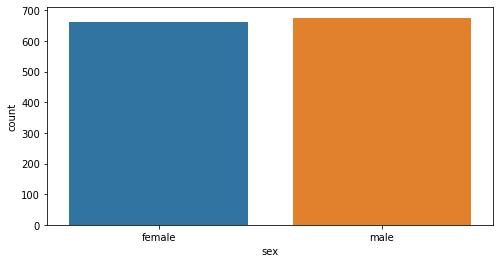

In [7]:
plt.figure(figsize=(8,4))
sns.countplot(data=data, x = 'sex' )

The male gender is having a slightly more population,but male and female are almost equal population.

<AxesSubplot:xlabel='age', ylabel='count'>

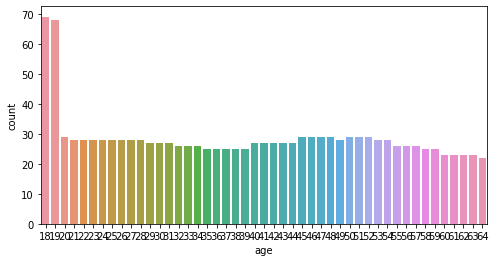

In [8]:
plt.figure(figsize=(8,4))
sns.countplot(data=data, x = 'age')

age column its shows there is more populatiion people from the age of 18,19 compared to other age people.

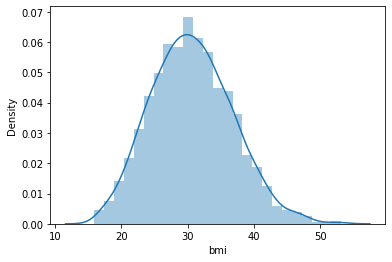

In [9]:
sns.distplot(data['bmi'])
plt.show()

<AxesSubplot:xlabel='children', ylabel='count'>

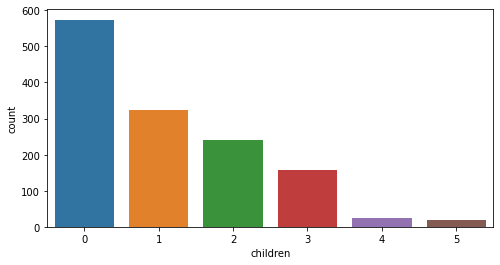

In [10]:
plt.figure(figsize=(8,4))
sns.countplot(data=data, x = 'children')

<AxesSubplot:xlabel='smoker', ylabel='count'>

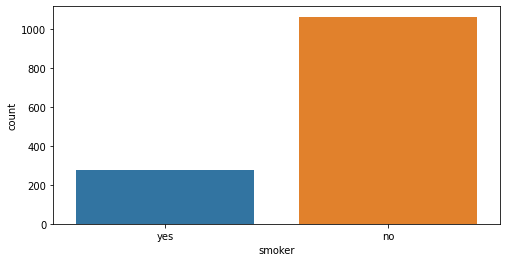

In [11]:
plt.figure(figsize=(8,4))
sns.countplot(data=data, x = 'smoker')

There is very less number of smokers in this dataset.

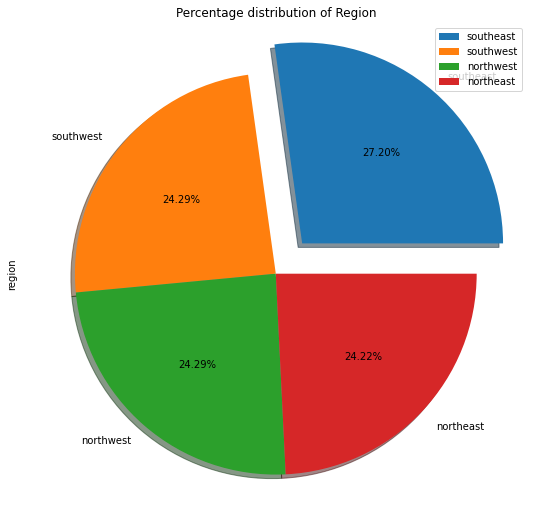

In [12]:
#plotting pie chart of the region feature
plt.figure(figsize=(9,9.5))
data['region'].value_counts().plot(kind='pie',explode=[0.2,0,0,0],legend=True,autopct='%.2f%%',shadow=True)
plt.title('Percentage distribution of Region')
plt.show()

Making our target variable normally distributed often will lead to better results.
If our target is not normally distributed, we can apply a transformation to it and then fit our regression to predict the transformed values.
How can we tell if our target is normally distributed? There are two ways:
* Visually
* Using a statistical test

This test outputs a "p-value". The higher this p-value is the closer the distribution is to normal.
some common transformations to try and get y to be normally distributed:
* Log
* Square root
* Box cox


<AxesSubplot:xlabel='charges', ylabel='Count'>

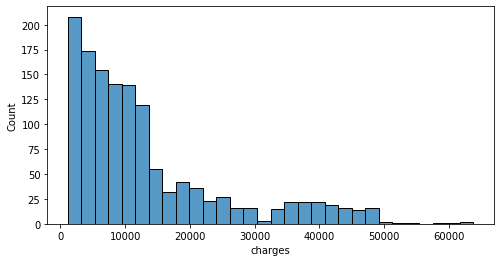

In [13]:
plt.figure(figsize=(8,4))
sns.histplot(data=data, x = 'charges' )

The Target does not appear to be normally distributed.

In [14]:
# Calculate Normaltest on target before apply log Transformation:
from scipy.stats.mstats import normaltest
print(normaltest(data.charges))

NormaltestResult(statistic=336.8851220567733, pvalue=7.019807901276197e-74)


As we can see pvalue is very low.

**Apply log transformation:**

In [15]:
data.charges = np.log1p(data.charges)
print(normaltest(data.charges))

NormaltestResult(statistic=52.75253430687823, pvalue=3.50697542068533e-12)


pvalue significantly increased.

<AxesSubplot:xlabel='charges', ylabel='Count'>

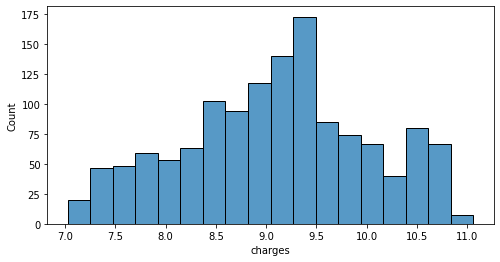

In [16]:
plt.figure(figsize=(8,4))
sns.histplot(data=data, x = 'charges' )

<a id="1"></a> <br>
# 4. Preprocessing

In [17]:
# categorical Features:
cat_features = [col for col in data.columns if data[col].dtypes=='object']

These categorical features are Nominal, so i used get_dummies function to encode these features:

In [18]:
# apply get_dummies:
for col in cat_features:
    dummy = pd.get_dummies(data[col], prefix=col)
    data = pd.merge(left=data, right=dummy, left_index=True, right_index=True)
    data.drop(col,axis=1,inplace=True)
columns = []

# reindex columns:
for col in data.columns:
    if col != 'charges':
        columns.append(col)
columns.append('charges')
data = data.reindex(columns=columns)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [20]:
X = data.drop('charges',axis=1)
y = data.charges

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

**Scaling:**

In [22]:
minmax = MinMaxScaler()
X_train_scaled = minmax.fit_transform(X_train)
X_test_scaled = minmax.transform(X_test)

<a id="1"></a> <br>
# 5. Modeling

**For the modeling part we will compare 8 known algorithms for Regression:**

1: Linear Regression

2: Ridge

3: Lasso

4: SVR

5: DecisionTreeRegressor

6: RandomForestRegressor

7: ExtraTreesRegressor

8: GradientBoostingRegressor

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [24]:
# Define classifiers:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=42)
Classifiers = []
Classifiers.append(LinearRegression())
Classifiers.append(Ridge())
Classifiers.append(Lasso())
Classifiers.append(SVR())
Classifiers.append(DecisionTreeRegressor())
Classifiers.append(RandomForestRegressor())
Classifiers.append(ExtraTreesRegressor())
Classifiers.append(GradientBoostingRegressor())

**Apply GridSearchCV:**

In [25]:
# define parameters for GridSearchCV:
param_grid_LR = {'fit_intercept':[True,False],
                'normalize':[True,False],
                 'copy_X':[True,False]}

param_grid_Ridge = {'alpha': [1,0.1,0.01,0.001,0.0001],
                    "fit_intercept": [True, False],
                    "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

param_grid_Lasso = {'alpha': [1,0.1,0.01,0.001,0.0001],
                    "fit_intercept": [True, False]}

param_grid_SVR = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
                   'C' : np.logspace(-3,3,7),
                   'gamma' : ['auto','scale']}

param_grid_DT = {"splitter":["best","random"],
                 "max_depth" : [1,3,5,7,9,11,12],
                 "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
                 "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                 "max_features":["auto","log2","sqrt",None],
                 "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]}

param_grid_RF = {'n_estimators': [100,200,300],
                 'max_features': ['auto', 'sqrt', 'log2'],
                 'max_depth' : np.arange(3,15)}

param_grid_ET = {'n_estimators': [100,200,300],
                 'max_features': ['auto', 'sqrt', 'log2'],
                 'max_depth' : np.arange(3,15)}

param_grid_GB = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample' : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,200,300],
                  'max_depth' : np.arange(5,15)}

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
# GridSearchCV for Linear Regression:
grid_LR = GridSearchCV(Classifiers[0],param_grid_LR, cv=kf, n_jobs=-1 )
grid_LR = grid_LR.fit(X_train_scaled,y_train)
print(grid_LR.best_params_)

{'copy_X': True, 'fit_intercept': True, 'normalize': True}


In [28]:
# GridSearchCV for Ridge:
grid_Ridge = GridSearchCV(Classifiers[1],param_grid_Ridge, cv=kf, n_jobs=-1 )
grid_Ridge = grid_Ridge.fit(X_train_scaled,y_train)
print(grid_Ridge.best_params_)

{'alpha': 0.001, 'fit_intercept': False, 'solver': 'sag'}


In [29]:
# GridSearchCV for Lasso:
grid_Lasso = GridSearchCV(Classifiers[2],param_grid_Lasso, cv=kf, n_jobs=-1 )
grid_Lasso = grid_Lasso.fit(X_train_scaled,y_train)
print(grid_Lasso.best_params_)

{'alpha': 0.001, 'fit_intercept': False}


In [30]:
# GridSearchCV for SVR:
grid_SVR = GridSearchCV(Classifiers[3],param_grid_SVR, cv=kf, n_jobs=-1 )
grid_SVR = grid_SVR.fit(X_train_scaled,y_train)
print(grid_SVR.best_params_)

{'C': 10.0, 'gamma': 'scale', 'kernel': 'poly'}


In [31]:
# GridSearchCV for DecisionTreeRegressor:
grid_DT = GridSearchCV(Classifiers[4],param_grid_DT, cv=kf, n_jobs=-1 )
grid_DT = grid_DT.fit(X_train_scaled,y_train)
print(grid_DT.best_params_)

{'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}


In [32]:
# GridSearchCV for RandomForestRegressor:
grid_RF = GridSearchCV(Classifiers[5],param_grid_RF, cv=kf, n_jobs=-1 )
grid_RF = grid_RF.fit(X_train_scaled,y_train)
print(grid_RF.best_params_)

{'max_depth': 4, 'max_features': 'auto', 'n_estimators': 300}


In [33]:
# GridSearchCV for ExtraTreesRegressor:
grid_ET = GridSearchCV(Classifiers[6],param_grid_ET, cv=kf, n_jobs=-1 )
grid_ET = grid_ET.fit(X_train_scaled,y_train)
print(grid_ET.best_params_)

{'max_depth': 6, 'max_features': 'auto', 'n_estimators': 300}


In [34]:
# GridSearchCV for GradientBoostingRegressor:
grid_GB = GridSearchCV(Classifiers[7],param_grid_GB, cv=kf, n_jobs=-1 )
grid_GB = grid_GB.fit(X_train_scaled,y_train)
print(grid_GB.best_params_)

{'learning_rate': 0.01, 'max_depth': 12, 'n_estimators': 300, 'subsample': 0.1}


In [35]:
from sklearn.metrics import r2_score

In [36]:
# Create LR Model:
model_LR = LinearRegression(copy_X = True, fit_intercept = True, normalize = True)
model_LR = model_LR.fit(X_train_scaled, y_train)
y_pred = model_LR.predict(X_test_scaled)
acc_LR = r2_score(y_test, y_pred)
r2_score(y_test, y_pred)

0.7782348031263425

In [37]:
# Create Ridge Model:
model_Ridge = Ridge(alpha = 1, fit_intercept = True, solver = 'lsqr')
model_Ridge = model_Ridge.fit(X_train_scaled, y_train)
y_pred = model_Ridge.predict(X_test_scaled)
acc_Ridge = r2_score(y_test, y_pred)
r2_score(y_test, y_pred)

0.7780335330864177

In [38]:
# Create Lasso Model:
model_Lasso = Lasso(alpha = 0.001, fit_intercept = False)
model_Lasso = model_Lasso.fit(X_train_scaled, y_train)
y_pred = model_Lasso.predict(X_test_scaled)
acc_Lasso = r2_score(y_test, y_pred)
r2_score(y_test, y_pred)

0.7778458010463347

In [39]:
# Create SVR Model:
model_SVR = SVR(C = 10, gamma = 'scale', kernel = 'poly')
model_SVR = model_SVR.fit(X_train_scaled, y_train)
y_pred = model_SVR.predict(X_test_scaled)
acc_SVR = r2_score(y_test, y_pred)
r2_score(y_test, y_pred)

0.8321128587862732

In [40]:
# Create DecisionTreeRegressor Model:
model_DT = DecisionTreeRegressor(max_depth = 5, max_features = 'auto', max_leaf_nodes = None,
                                 min_samples_leaf = 1, min_weight_fraction_leaf = 0.1, splitter = 'best')
model_DT = model_DT.fit(X_train_scaled, y_train)
y_pred = model_DT.predict(X_test_scaled)
acc_DT = r2_score(y_test, y_pred)
r2_score(y_test, y_pred)

0.791632210663503

In [41]:
# Create RandomForestRegressor Model:
model_RF = RandomForestRegressor(max_depth = 4, max_features = 'auto', n_estimators = 200)
model_RF = model_RF.fit(X_train_scaled, y_train)
y_pred = model_RF.predict(X_test_scaled)
acc_RF = r2_score(y_test, y_pred)
r2_score(y_test, y_pred)

0.8234436473722863

In [42]:
# Create ExtraTreesRegressor Model:
model_ET = ExtraTreesRegressor(max_depth = 6, max_features = 'auto', n_estimators = 300)
model_ET = model_ET.fit(X_train_scaled, y_train)
y_pred = model_ET.predict(X_test_scaled)
acc_ET = r2_score(y_test, y_pred)
r2_score(y_test, y_pred)

0.835216859493654

In [43]:
# Create GradientBoostingRegressor Model:
model_GB = GradientBoostingRegressor(learning_rate = 0.01, max_depth = 6, n_estimators = 300, subsample = 0.1)
model_GB = model_GB.fit(X_train_scaled, y_train)
y_pred = model_GB.predict(X_test_scaled)
acc_GB = r2_score(y_test, y_pred)
r2_score(y_test, y_pred)

0.8269921102443939

In [44]:
final_result = pd.Series({'Linear Regression':acc_LR,
                         'Ridge':acc_Ridge,
                         'Lasso':acc_Lasso,
                         'SVR':acc_SVR,
                         'DecisionTreeRegressor':acc_DT,
                         'RandomForestRegressor':acc_RF,
                         'ExtraTreesRegressor':acc_ET,
                         'GradientBoostingRegressor':acc_GB})

In [45]:
final_result = pd.DataFrame(final_result,columns=['Accuracy']).sort_values(by = 'Accuracy', ascending=False)

In [46]:
final_result

,Accuracy
ExtraTreesRegressor,0.835217
SVR,0.832113
GradientBoostingRegressor,0.826992
RandomForestRegressor,0.823444
DecisionTreeRegressor,0.791632
Linear Regression,0.778235
Ridge,0.778034
Lasso,0.777846


**AS We can see ExtraTreesRegressor has the best performance in comparison with other algorithms.**